In [1]:
# %%
import os, json
import importlib
import torch
import torch_geometric

# deprecated in torch_geometric 2.0
try:
    from torch_geometric.loader import DataLoader
except:
    from torch_geometric.data import DataLoader

import hydragnn
#importlib.reload(hydragnn)
import voronoi_utils as voronoi_utils
#importlib.reload(vfiber_utils)

import torch_geometric.transforms as T

import numpy as np
# import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

dataset = voronoi_utils.VoronoiNet(root='.')
pf = 'pf_82'
# %%
# Set this path for output.
try:
    os.environ["SERIALIZED_DATA_PATH"]
except:
    os.environ["SERIALIZED_DATA_PATH"] = os.getcwd()

filename = os.path.join(os.getcwd(), f"{pf}/config.json")
with open(filename, "r") as f:
    config = json.load(f)
verbosity = config["Verbosity"]["level"]
var_config = config["NeuralNetwork"]["Variables_of_interest"]

# Always initialize for multi-rank training.
world_size, world_rank = hydragnn.utils.setup_ddp()

log_name = "pf_optuna"
hydragnn.utils.setup_log(log_name)

train, val, test = hydragnn.preprocess.split_dataset(
    dataset, config["NeuralNetwork"]["Training"]["perc_train"], False
)
(train_loader, val_loader, test_loader,) = hydragnn.preprocess.create_dataloaders(
    train, val, test, config["NeuralNetwork"]["Training"]["batch_size"]
)

config = hydragnn.utils.update_config(config, train_loader, val_loader, test_loader)

model = hydragnn.models.create_model_config(
    config=config["NeuralNetwork"],
    verbosity=verbosity,
)
model = hydragnn.utils.get_distributed_model(model, verbosity)

learning_rate = config["NeuralNetwork"]["Training"]["Optimizer"]["learning_rate"]
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=0.000001
)


[2025-03-29 20:59:22,454] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Distributed data parallel: nccl master at 127.0.0.1:8890


Degree bincount: 100%|██████████| 800/800 [00:00<00:00, 36311.57it/s]
0: Using GPU
0: Using GPU


In [2]:
from hydragnn.utils.model import load_existing_model
modelname = pf
log_name = "pf_optuna"
load_existing_model(model, modelname, path=".")
model.eval()


0: Load existing model: ./pf_82/pf_82.pk


DistributedDataParallel(
  (module): PNAStack(
    (graph_convs): ModuleList(
      (0): Sequential(
        (0) - PNAConv(2, 196, towers=1, edge_dim=3): x, edge_index, edge_attr -> x
        (1) - <function PNAStack.get_conv.<locals>.<lambda> at 0x7fcd1028b560>: x, pos -> x, pos
      )
      (1): Sequential(
        (0) - PNAConv(196, 196, towers=1, edge_dim=3): x, edge_index, edge_attr -> x
        (1) - <function PNAStack.get_conv.<locals>.<lambda> at 0x7fccfa7ade40>: x, pos -> x, pos
      )
      (2): Sequential(
        (0) - PNAConv(196, 196, towers=1, edge_dim=3): x, edge_index, edge_attr -> x
        (1) - <function PNAStack.get_conv.<locals>.<lambda> at 0x7fccfa7ad3a0>: x, pos -> x, pos
      )
      (3): Sequential(
        (0) - PNAConv(196, 196, towers=1, edge_dim=3): x, edge_index, edge_attr -> x
        (1) - <function PNAStack.get_conv.<locals>.<lambda> at 0x7fccfa7aca40>: x, pos -> x, pos
      )
    )
    (feature_layers): ModuleList(
      (0-3): 4 x BatchNorm(196)


In [3]:
from hydragnn.utils.distributed import get_device
from tqdm import tqdm
# Combine validation and test sets for inference
combined_test =  test + val


f_max= 3772.923583984375 
f_min= 2866.879638671875 
f_range= 906.0439453125

num_samples = len(combined_test)
true_values = []
predicted_values = []

denormalized_predicted_values = []
denormalized_true_values = []
test_MAE = 0.0
variable_index = 0

for data_id, data in enumerate(tqdm(combined_test)):
    predicted = model(data.to(get_device()))
    predicted = predicted[variable_index].flatten()
    true = data.y
    # start = data.y[0][variable_index].item()
    # end = data.y[0][variable_index + 1].item()
    # true = data.y[start:end, 0]
    # test_MAE += torch.norm(predicted - true, p=1).item() / len(test)
    predicted_values.append(predicted.cpu().tolist())
    denormalized_predicted_values.append((predicted * f_range + f_min).cpu().tolist())
    true_values.append(true.cpu().tolist())
    denormalized_true_values.append((true * f_range + f_min).cpu().tolist())

100%|██████████| 200/200 [00:02<00:00, 97.64it/s] 


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
sty = 'default'
mpl.style.use(sty)

plt.rcParams.update({}) #'lines.linewidth': 1.5, 
#                        'markers.fillstyle': 'bottom',
                     
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 22

plt.rcParams["text.latex.preamble"].join([
        r"\usepackage{setspace}",              
        r"\setmainfont{lipsum}",
        r"\usepackage{amsmath}",
        r"\usepackage{amssymb}",
        r"\usepackage{amsthm}",
        r"\usepackage{amsfonts}",
        r"\usepackage{bm}",
        r"\usepackage{comment}",
        r"\usepackage{multirow}",
        r"\usepackage{multicol}"
])


'\\usepackage{setspace}\\setmainfont{lipsum}\\usepackage{amsmath}\\usepackage{amssymb}\\usepackage{amsthm}\\usepackage{amsfonts}\\usepackage{bm}\\usepackage{comment}\\usepackage{multirow}\\usepackage{multicol}'

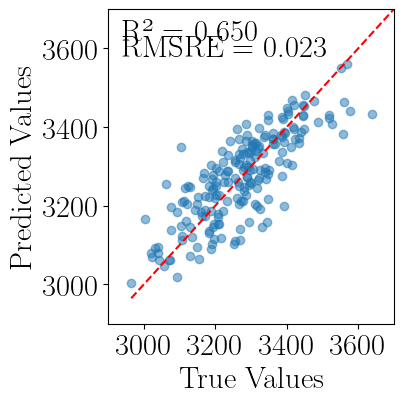

In [11]:


# Flatten lists if needed
true_flat = [item for sublist in denormalized_true_values for item in sublist]
pred_flat = [item for sublist in denormalized_predicted_values for item in sublist]

# Create the parity plot
plt.figure(figsize=(4.5, 4.5))
plt.scatter(true_flat, pred_flat, alpha=0.5)

# Add parity line
min_val = min(min(true_flat),min(pred_flat))
max_val = max(max(true_flat),max(pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

# Calculate and display R2 score
r2 = np.corrcoef(true_flat, pred_flat)[0,1]**2
plt.text(0.05, 0.9, f'R² = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate RMSRE (Root Mean Square Relative Error)
rmsre = np.sqrt(np.mean(((np.array(true_flat) - np.array(pred_flat)) / np.array(true_flat)) ** 2))
plt.text(0.05, 0.85, f'RMSRE = {rmsre:.3f}', transform=plt.gca().transAxes)

plt.text

plt.xlim(2900,3700)
plt.ylim(2900,3700)

plt.xticks([3000,3200,3400,3600])

plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# plt.title('Parity Plot: Predicted vs True Values')
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig('predictions-peak-load.pdf')
plt.show()


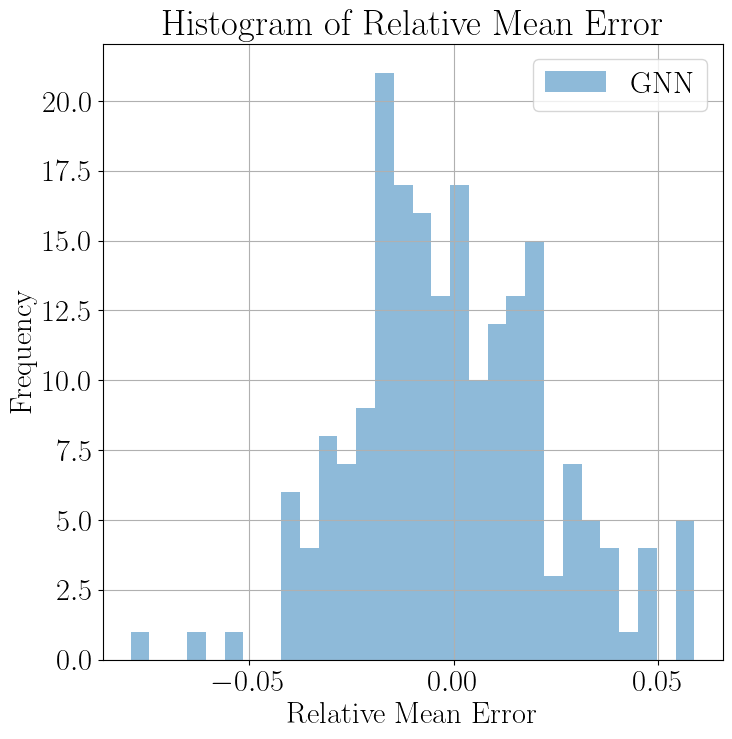

In [7]:
# Calculate relative errors for both models
rmre_gnn = (np.array(true_flat) - np.array(pred_flat)) / np.array(true_flat)
# rmre_unet = (np.array(true_vals) - np.array(pred_vals)) / np.array(true_vals)

# Create histogram plot
plt.figure(figsize=(8, 8))
plt.hist(rmre_gnn, bins=30, alpha=0.5, label='GNN')
# plt.hist(rmre_unet, bins=30, alpha=0.5, label='UNet')

plt.xlabel('Relative Mean Error')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Mean Error')
plt.legend()
plt.grid(True)
plt.show()

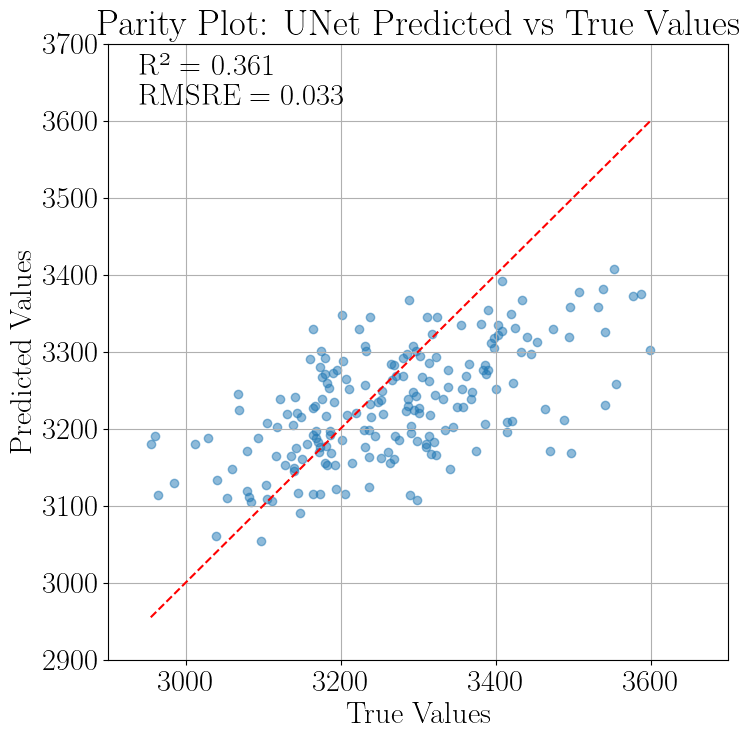

In [24]:
# Read data from CSV file manually
true_vals_unet = []
pred_vals_unet = []
with open('gao_data.csv', 'r') as f:
    for line in f:
        true, pred = line.strip().split(',')
        pred_vals_unet.append(float(true))
        true_vals_unet.append(float(pred))


# Create a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(true_vals_unet, pred_vals_unet, alpha=0.5)

# Add parity line
min_val = min(min(true_vals_unet), min(pred_vals_unet))
max_val = max(max(true_vals_unet), max(pred_vals_unet))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Parity Line')

# Calculate and display R2 score
r2_unet = np.corrcoef(true_vals_unet, pred_vals_unet)[0,1]**2
plt.text(0.05, 0.95, f'R² = {r2_unet:.3f}', transform=plt.gca().transAxes)

# Calculate RMSRE (Root Mean Square Relative Error)
rmsre_unet = np.sqrt(np.mean(((np.array(true_vals_unet) - np.array(pred_vals_unet)) / np.array(true_vals_unet)) ** 2))
plt.text(0.05, 0.90, f'RMSRE = {rmsre_unet:.3f}', transform=plt.gca().transAxes)


plt.xlim(2900,3700)
plt.ylim(2900,3700)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot: UNet Predicted vs True Values')
plt.grid(True)
plt.show()


In [1]:
from sklearn.metrics import r2_score
# # Flatten lists if needed
# true_flat = [item for sublist in denormalized_true_values for item in sublist]
pred_flat = [item for sublist in denormalized_predicted_values for item in sublist]

# Create the parity plot
plt.figure(figsize=(4.5, 4.5))

r2_gnn = r2_score(true_flat, pred_flat)
r2_unet = r2_score(true_vals_unet, pred_vals_unet)


plt.scatter(pred_vals_unet, true_vals_unet, alpha=0.7, label=r'UNET, $R^2$ = {r:.2f}'.format(r=r2_unet))
plt.scatter(pred_flat, true_flat, alpha=0.7, label=r'GNN, $R^2$ = {r:.2f}'.format(r=r2_gnn))
# Add parity line

min_val = min(min(true_flat),min(pred_flat))
max_val = max(max(true_flat),max(pred_flat))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='x=y')

# Calculate and display R2 score
# plt.text(0.05, 0.9, r'GNN $R^2$ = {r:.2f}'.format(r=r2), transform=plt.gca().transAxes)

# Calculate RMSRE (Root Mean Square Relative Error)
# rmsre = np.sqrt(np.mean(((np.array(true_flat) - np.array(pred_flat)) / np.array(true_flat)) ** 2))
# plt.text(0.05, 0.85, f'RMSRE = {rmsre:.3f}', transform=plt.gca().transAxes)

plt.text

plt.xlim(2900,3700)
plt.ylim(2900,3700)

plt.xticks([3000,3200,3400,3600])

plt.xlabel('Predicted peak load')
plt.ylabel('True peak load')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# plt.title('Parity Plot: Predicted vs True Values')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig('predictions-peak-load.pdf',bbox_inches='tight')
plt.show()


NameError: name 'denormalized_predicted_values' is not defined